# Depression and Anxiety classification with CSP spatial filter

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [1]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score


import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

Constatnts

In [2]:
random_state = 42

## Load questionnarie data

In [3]:
data = pd.read_csv('data/q_data.csv')

In [4]:
data['disorder'] = 0
for i in range(len(data)):
    if data['BDI'][i] != '#NULL!' and data['BDI'][i] >= 13:
        data['disorder'][i] = 1
    else:
        data['disorder'][i] = 0

/tmp/ipykernel_10299/1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
/tmp/ipykernel_10299/1494664159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 1


In [5]:
data

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder
0,507,99.0,NaN,1,19,0.0,0.00,0.00,0.00,23.0,...,753.41,722.02,828.73,728.22,721.10,905.28,785.73,0.12,0.00,0
1,508,99.0,NaN,1,18,4.0,0.00,0.67,0.17,47.0,...,932.63,772.36,986.75,771.20,896.43,1202.03,968.84,0.28,0.93,0
2,509,99.0,NaN,1,18,7.0,0.17,0.00,0.67,44.0,...,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0
3,510,99.0,NaN,1,19,1.0,0.00,0.00,0.17,27.0,...,1239.09,1231.04,1500.54,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0
4,511,99.0,NaN,2,22,1.0,0.00,0.00,0.17,23.0,...,1527.80,1908.43,1305.88,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,624,1.0,NaN,1,20,23.0,1.33,1.00,0.67,60.0,...,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81,1
117,625,2.0,subsyndromal current,1,19,16.0,0.67,1.00,0.83,60.0,...,1149.39,1130.02,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00,1
118,626,1.0,NaN,1,18,14.0,0.33,1.00,0.83,41.0,...,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38,1
119,627,2.0,NaN,2,19,30.0,1.00,1.33,2.17,47.0,...,2131.00,2065.05,2270.20,2167.89,1941.75,2261.39,2320.25,0.10,0.61,1


In [6]:
ids = data['id'][:].astype(int)

## Load EEG data

In [7]:
ctrl_dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['TAI'][part] > 28]
ctrl_dep = pd.DataFrame(ctrl_dep)
len(ctrl_dep)

47

In [8]:
dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] > 13.0 and data['TAI'][part] > 28]
dep = pd.DataFrame(dep)
len(dep)

45

In [9]:
anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] > 30) and (data['BDI'][part] < 13)]
anx = pd.DataFrame(anx)
len(anx)

35

In [10]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] < 13 and data['TAI'][part] < 30]
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

33

In [11]:
def read_epochs(arr, group):
    for i in range(len(group)):
        fname = str(int(group.values[i, 0])) + "-epo.fif"
        print("\n\n" + fname)
        # this one doesn't exist
        if fname == "599-epo.fif" or fname == "600-epo.fif":
            continue
        arr.append(mne.read_epochs('data/' + fname))

In [12]:
%%capture

dep_epochs = []
read_epochs(dep_epochs, dep)

In [13]:
len(dep_epochs)

45

In [14]:
%%capture

ctrl_dep_epochs = []
read_epochs(ctrl_dep_epochs, ctrl_dep)

In [15]:
len(ctrl_dep_epochs)

45

In [16]:
%%capture

anx_epochs = []
read_epochs(anx_epochs, anx)

In [17]:
len(anx_epochs)

33

In [18]:
%%capture

ctrl_anx_epochs = []
read_epochs(ctrl_anx_epochs, ctrl_anx)

In [19]:
len(ctrl_anx_epochs)

33

## Classification

In [20]:
# Calculating p-value with permutation test from sci-kit learn

def calculate_p_permutations(estimator, X, y, cv=3, n_permutations=1000, n_jobs=1):

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator, X, y, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs
    )

    # summarize
    print(f"     The permutation P-value is = {pvalue_:.4f}")
    print(f"     The permutation score is = {score_:.4f}\n")

    return score_, pvalue_

In [21]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    classifier_params,
    pipeline_name,
    cv=StratifiedKFold(n_splits=5),
    predict_test = True,
    predict_train = True,
    ):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        classifier_params,
        cv=cv,
        scoring={"roc_auc", "balanced_accuracy", "precision", "recall"},
        refit="balanced_accuracy",
        return_train_score=True,
        verbose=10,
        n_jobs=1,
        
    )

    # fit model
    grid_search_model.fit(X_train, y_train)

    # predict test data
    # y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    # test_score = roc_auc_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X_train) if predict_train is True else None
    train_score = roc_auc_score(y_train, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_
    
    # report
    # classification_report_ = classification_report(y_test, y_test_pred, labels=[0,1])

    # extract splits scores
    # ta linijka wyciąga z cv_results, czyli z DF z wynikami wszystkich testowanych 
    # w GS parametrów scory na kolejnych splitach cross-validacji
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_roc_auc").reset_index(drop=True) 

    # wyciąganie scorów na teście dla matryk zdefiniowanych w scoring
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)
    
    # calculate p-value
    scores_, pvalue_ = calculate_p_permutations(
            grid_search_model.best_estimator_, X_train, y_train, cv=cv
        )


    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            # "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            "pvalue":[pvalue_],    
            }),
         cv_splits_scores_df,
         metrics_results_df,
        ],
    axis=1
    ) 

    return this_result

Define estimators

In [22]:
lg = ('lg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))
lg_params = dict()

svc = ('svc' , SVC())
svc_params = dict(
    svc__kernel=["linear", "rbf"],
    svc__C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

lda = ("lda", LinearDiscriminantAnalysis())
lda_params = dict(
    lda__solver = ["lsqr", "eigen"],
    lda__shrinkage = ["auto"],
)


estimators = [
    (lg, lg_params),
    (svc, svc_params),
    (lda, lda_params)
]

Define CSP

In [23]:
csp = ('csp', CSP(log=None, norm_trace=False))
csp_params = dict(
    csp__n_components = [1,2,3,4],
    csp__reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
)

### Depression vs Control

#### RewP

In [24]:
tmin = 0.25
tmax = 0.35

dep_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep_epochs]
ctrl_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep_epochs]

In [25]:
X = np.array(dep_data + ctrl_data)
y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])

In [26]:
len(y)

90

In [634]:
%%capture

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)


results_dep_rewp_df = pd.DataFrame()

global_params = csp_params

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")

    pipeline_name = "RewP_Depression_" + estimator[0]

    clf = Pipeline([csp] + [('vec', vec)] + [estimator])
    classifier_params = {**global_params, **params}
    
    # enter to grid search
    grid_result = evaluate_GS_model(
        clf,
        X,
        y,
        [],
        [],
        classifier_params = classifier_params,
        pipeline_name = pipeline_name,
        cv=cv,
    )
    
    print(grid_result)

    results_dep_rewp_df = pd.concat([results_dep_rewp_df, grid_result])

In [635]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_precision,mean_test_balanced_accuracy,mean_test_recall
0,lg,RewP_Depression_lg,0.822222,0.611111,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.001}",0.027972,0.453333,0.582222,0.573333,0.536296,0.646128,0.611111,0.488889
0,svc,RewP_Depression_svc,0.711111,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 1, 'svc__...",0.014985,0.755556,0.626667,0.582222,0.654815,0.658120,0.644444,0.600000
0,lda,RewP_Depression_lda,0.611111,0.577778,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.1, 'lda...",0.090909,0.551111,0.675556,0.448889,0.558519,0.567677,0.577778,0.511111


In [663]:
results_dep_rewp_df.to_pickle("data/depression_rewp_results_3_02_03_24-00.pkl")

#### FRN

In [636]:
tmin = 0.25
tmax = 0.37

dep_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep_epochs]
ctrl_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep_epochs]

In [637]:
X = np.array(dep_data + ctrl_data)
y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])

In [638]:
len(X)

90

In [639]:
%%capture
vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.2, random_state=42)
# cv = ShuffleSplit(3, test_size=0.3, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)


results_dep_frn_df = pd.DataFrame()

global_params = csp_params

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")

    pipeline_name = "FRN_Depression_" + estimator[0]

    clf = Pipeline([csp] + [('vec', vec)] + [estimator])
    classifier_params = {**global_params, **params}
    
    # enter to grid search
    grid_result = evaluate_GS_model(
        clf,
        X,
        y,
        [],
        [],
        classifier_params = classifier_params,
        pipeline_name = pipeline_name,
        cv=cv,
    )
    
    print(grid_result)

    results_dep_frn_df = pd.concat([results_dep_frn_df, grid_result])

In [640]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_precision,mean_test_balanced_accuracy,mean_test_recall
0,lg,FRN_Depression_lg,0.722222,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.01}",0.035964,0.555556,0.591111,0.644444,0.597037,0.611111,0.600000,0.533333
0,svc,FRN_Depression_svc,0.800000,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.001, 's...",0.026973,0.560000,0.617778,0.600000,0.592593,0.659091,0.600000,0.422222
0,lda,FRN_Depression_lda,0.833333,0.588889,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.001, 'l...",0.056943,0.582222,0.640000,0.617778,0.613333,0.658333,0.588889,0.422222


In [664]:
results_dep_frn_df.to_pickle("data/depression_frn_results_3_02_03_24-00.pkl")

In [ ]:
# # plot CSP patterns estimated on full data for visualization
# epochs_train = dep_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train.info

# csp.fit_transform(evoked_data, y)

# fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [ ]:
# clf.fit(evoked_data, y)

# clf[-1].coef_

### Anxiety vs Control

#### RewP

In [61]:
tmin = 0.25
tmax = 0.35

anx_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [62]:
X = np.array(anx_data + ctrl_data)
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])

In [63]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 33
CTR len: 33


In [64]:
%%capture
vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)


results_anx_rewp_df = pd.DataFrame()

global_params = csp_params

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")

    pipeline_name = "RewP_Anxiety_" + estimator[0]

    clf = Pipeline([csp] + [('vec', vec)] + [estimator])
    classifier_params = {**global_params, **params}
    
    # enter to grid search
    grid_result = evaluate_GS_model(
        clf,
        X,
        y,
        [],
        [],
        classifier_params = classifier_params,
        pipeline_name = pipeline_name,
        cv=cv,
    )
    
    print(grid_result)

    results_anx_rewp_df = pd.concat([results_anx_rewp_df, grid_result])

In [66]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_balanced_accuracy,mean_test_recall,mean_test_roc_auc,mean_test_precision
0,lg,RewP_Anxiety_lg,0.803030,0.666667,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1}",0.013986,0.661157,0.884298,0.504132,0.666667,0.727273,0.683196,0.643579
0,svc,RewP_Anxiety_svc,0.818182,0.681818,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.012987,0.644628,0.842975,0.504132,0.681818,0.757576,0.663912,0.666500
0,lda,RewP_Anxiety_lda,0.787879,0.666667,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'lda...",0.016983,0.611570,0.909091,0.512397,0.666667,0.787879,0.677686,0.628571


In [67]:
results_anx_rewp_df.to_pickle("data/anxiety_rewp_results_3_21_03_11-30.pkl")

#### FRN

In [68]:
tmin = 0.25
tmax = 0.37

anx_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [69]:
X = np.array(anx_data + ctrl_data)
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])

In [70]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 33
CTR len: 33


In [71]:
%%capture

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)


results_anx_frn_df = pd.DataFrame()

global_params = csp_params

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")

    pipeline_name = "FRN_Anxiety_" + estimator[0]

    clf = Pipeline([csp] + [('vec', vec)] + [estimator])
    classifier_params = {**global_params, **params}
    
    # enter to grid search
    grid_result = evaluate_GS_model(
        clf,
        X,
        y,
        [],
        [],
        classifier_params = classifier_params,
        pipeline_name = pipeline_name,
        cv=cv,
    )
    
    print(grid_result)

    results_anx_frn_df = pd.concat([results_anx_frn_df, grid_result])

In [72]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_balanced_accuracy,mean_test_recall,mean_test_roc_auc,mean_test_precision
0,lg,FRN_Anxiety_lg,0.893939,0.621212,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1}",0.037962,0.776860,0.719008,0.677686,0.621212,0.666667,0.724518,0.617827
0,svc,FRN_Anxiety_svc,0.939394,0.712121,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1, 'svc...",0.000999,0.826446,0.826446,0.661157,0.712121,0.848485,0.771350,0.668651
0,lda,FRN_Anxiety_lda,0.893939,0.696970,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'lda...",0.000999,0.644628,0.776860,0.644628,0.696970,0.787879,0.688705,0.664502


In [73]:
results_anx_frn_df.to_pickle("data/anxiety_frn_results_3_21_03_11-30.pkl")

In [ ]:
# # plot CSP patterns estimated on full data for visualization
# # epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_channels(['P1', 'P2', 'P4', 'P3', 'CP3', 'CP4', 'CP1', 'CP2', 'Pz', 'CPz',])

# epochs_train.info

# csp.fit_transform(evoked_data, y)

# fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

## Test statistical differences between models

In [45]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X_1,
    X_2,
    y,
    scoring='accuracy',
    random_state=0  
):
    """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    cv_scores_1 = cross_val_score(estimator1, X_1, y, cv=cv, scoring=scoring)
    cv_scores_2 = cross_val_score(estimator2, X_2, y, cv=cv, scoring=scoring)

    differences = cv_scores_1 - cv_scores_2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    n_train = len(list(cv.split(X_1, y))[0][0])
    n_test = len(list(cv.split(X_1, y))[0][1])

    t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

    return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [30]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_results_3_02_03_24-00.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_results_3_02_03_24-00.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_results.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_results_25_37.pkl")

### Depression RewP vs FRN

In [34]:
y = np.array(len(dep_epochs) * [1] +  len(ctrl_dep_epochs) * [0])

In [35]:
tmin = 0.25
tmax = 0.35

dep_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep_epochs]
ctrl_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep_epochs]

In [36]:
X_rewp = np.array(dep_rewp_data + ctrl_rewp_data)

In [37]:
tmin = 0.25
tmax = 0.37

dep_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep_epochs]
ctrl_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep_epochs]

In [38]:
X_frn = np.array(dep_frn_data + ctrl_frn_data)

#### Plot differences between all Depression Models
To see which RewP and FRN models are the best

In [39]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_dep_rewp_df)):
    cv_scores_rewp = cross_val_score(results_dep_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_dep_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [40]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.500,0.475,0.575,0.450,0.600,0.700
1,0.450,0.575,0.625,0.800,0.350,0.575
2,0.500,0.875,0.675,0.475,0.650,0.775
3,0.575,0.450,0.675,0.750,0.525,0.325
4,0.350,0.325,0.325,0.500,0.550,0.375
...,...,...,...,...,...,...
95,0.300,0.425,0.800,0.550,0.675,0.650
96,0.400,0.125,0.650,0.375,0.550,0.125
97,0.650,0.450,0.625,0.425,0.575,0.550
98,0.650,0.425,0.550,0.000,0.550,0.450


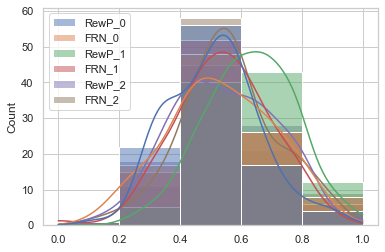

In [42]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [31]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_precision,mean_test_balanced_accuracy,mean_test_recall
0,lg,RewP_Depression_lg,0.822222,0.611111,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.001}",0.027972,0.453333,0.582222,0.573333,0.536296,0.646128,0.611111,0.488889
0,svc,RewP_Depression_svc,0.711111,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 1, 'svc__...",0.014985,0.755556,0.626667,0.582222,0.654815,0.658120,0.644444,0.600000
0,lda,RewP_Depression_lda,0.611111,0.577778,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.1, 'lda...",0.090909,0.551111,0.675556,0.448889,0.558519,0.567677,0.577778,0.511111


In [32]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_precision,mean_test_balanced_accuracy,mean_test_recall
0,lg,FRN_Depression_lg,0.722222,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.01}",0.035964,0.555556,0.591111,0.644444,0.597037,0.611111,0.600000,0.533333
0,svc,FRN_Depression_svc,0.800000,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.001, 's...",0.026973,0.560000,0.617778,0.600000,0.592593,0.659091,0.600000,0.422222
0,lda,FRN_Depression_lda,0.833333,0.588889,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.001, 'l...",0.056943,0.582222,0.640000,0.617778,0.613333,0.658333,0.588889,0.422222


In [33]:
dep_rewp_model = results_dep_rewp_df.iloc[1].best_model
dep_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': 1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f41f53484f0>),
                ('svc', SVC(C=100, kernel='linear'))])

In [43]:
dep_frn_model = results_dep_frn_df.iloc[0].best_model
dep_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.01,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f41f48b2eb0>),
                ('lg', LogisticRegression(penalty='l1', solver='liblinear'))])

- Balanced Accuracy

In [46]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [651]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.383
p value: 0.085


- Roc AUC

In [47]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [48]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.359
p value: 0.089


- precision

In [49]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [50]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.463
p value: 0.073


- recall

In [51]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [52]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.808
p value: 0.210


- F1

In [53]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [54]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.157
p value: 0.125


Visualize difference between FRN and RewP models

In [55]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [56]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

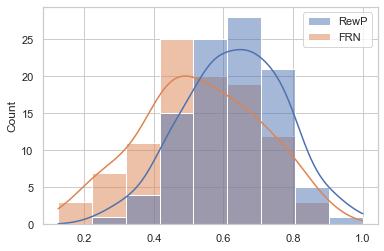

In [57]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [58]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [59]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

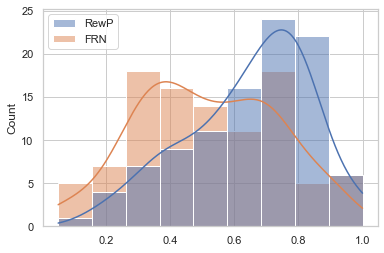

In [60]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

### Anxiety RewP vs FRN

In [105]:
y = np.array(len(anx_epochs) * [1] +  len(ctrl_anx_epochs) * [0])

In [106]:
tmin = 0.25
tmax = 0.35

anx_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [107]:
X_rewp = np.array(anx_rewp_data + ctrl_rewp_data)

In [108]:
tmin = 0.25
tmax = 0.37

anx_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [109]:
X_frn = np.array(anx_frn_data + ctrl_frn_data)

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [79]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_anx_rewp_df)):
    cv_scores_rewp = cross_val_score(results_anx_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_anx_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [80]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.125000,0.708333,0.291667,0.708333,0.125000,0.541667
1,0.291667,0.875000,0.458333,0.833333,0.291667,0.833333
2,0.708333,0.291667,0.708333,0.291667,0.708333,0.458333
3,0.750000,0.875000,0.750000,0.750000,0.750000,0.875000
4,0.875000,0.750000,0.750000,0.750000,0.875000,0.875000
...,...,...,...,...,...,...
95,0.750000,0.875000,0.750000,0.625000,0.583333,0.541667
96,0.333333,0.000000,0.333333,0.333333,0.333333,0.166667
97,0.500000,0.666667,0.333333,0.333333,0.333333,0.666667
98,0.666667,0.666667,0.666667,0.833333,0.666667,0.833333


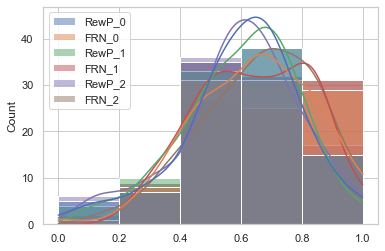

In [82]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [83]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_balanced_accuracy,mean_test_recall,mean_test_roc_auc,mean_test_precision
0,lg,RewP_Anxiety_lg,0.803030,0.666667,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1}",0.013986,0.661157,0.884298,0.504132,0.666667,0.727273,0.683196,0.643579
0,svc,RewP_Anxiety_svc,0.818182,0.681818,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.012987,0.644628,0.842975,0.504132,0.681818,0.757576,0.663912,0.666500
0,lda,RewP_Anxiety_lda,0.787879,0.666667,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'lda...",0.016983,0.611570,0.909091,0.512397,0.666667,0.787879,0.677686,0.628571


In [84]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_balanced_accuracy,mean_test_recall,mean_test_roc_auc,mean_test_precision
0,lg,FRN_Anxiety_lg,0.893939,0.621212,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1}",0.037962,0.776860,0.719008,0.677686,0.621212,0.666667,0.724518,0.617827
0,svc,FRN_Anxiety_svc,0.939394,0.712121,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1, 'svc...",0.000999,0.826446,0.826446,0.661157,0.712121,0.848485,0.771350,0.668651
0,lda,FRN_Anxiety_lda,0.893939,0.696970,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'lda...",0.000999,0.644628,0.776860,0.644628,0.696970,0.787879,0.688705,0.664502


In [103]:
anx_rewp_model = results_anx_rewp_df.iloc[1].best_model
anx_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f41f3a1cdf0>),
                ('svc', SVC(C=1, kernel='linear'))])

In [104]:
anx_frn_model = results_anx_frn_df.iloc[1].best_model
anx_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f41f3d8f880>),
                ('svc', SVC(C=10))])

- Balanced Accuracy

In [87]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [88]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.538
p value: 0.296


- Roc AUC

In [110]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [111]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.700
p value: 0.243


- precision

In [91]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [92]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.555
p value: 0.290


- recall

In [93]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [94]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.367
p value: 0.357


- F1

In [95]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [96]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.544
p value: 0.294


Visualize difference between FRN and RewP models

In [97]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [98]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

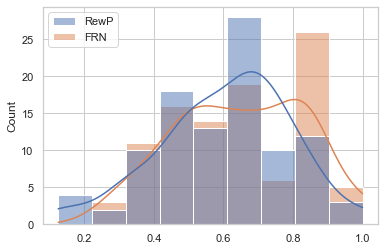

In [99]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [100]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [101]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

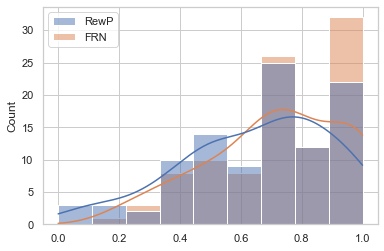

In [102]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)